## COMMENT INFO 

In [252]:
"""
status - A=203 , B=31 ,C=403 ,D=45 total - 682 loans - good - a&c= 606 ,  bad - b&d= 76 - class imbalance -87.5 % good.

july 1993 to dec 1998-loan & credit cards issued , so the review is being done in 1999 ,all the demographics data is 
from 1995-1996, transcations data from 1995-1998 , account creation - 1993 to 1997 dec.

Temporal stability - even though the loans are given in different points in time , we consider the analysis of loan 
performance when the loan is at the approval stage for the training set i.e at the date of issuance of loan.

what is the training & test set & what are the dependent variables & what are we trying to predict using machine learning &
at what time frame. What is known & unknown to us ( labelled & unlabelled data).

goal- defining our business problem , what we want to predict , what is known to us & making sense of the data. 

domain knowledge - here it looks like looking at the status after loan contract ended , if loan not paid then
it is taken as not paid, 

czech coruna 25-30 usd in 1990's , 6 years worth of bank data 

average date after taking loan when negative balance started. creating right labels.

DEALING WITH TARGET VARIABLE BINNING - trying to reduce misclassification error. C & D - Since we have less instances 
of bad loans & also all the negative balance parameters of b&d match , so we can consider all instances of 'D'
as bad loans(considering it as deliquiency).Earliest deliquiency is 2 months, 4 loans in d which have gone bad within a year i.e C which is not A & D which is not B.
TRIED TO FIND SOME CRITERION BUT COULDN'T, so just conisder the basic assumption.

setting an upper bound for loan amount for 600k & duration for 5 years , since we don't have data for time period greater
than this

checking the performance of the model , stratified k fold & using cohen kappa , f1 , prcurve

accurate measure of fixed_salary of the client & average_balance in some useful form.- average transcation & order amount.


"""

"\nstatus - A=203 , B=31 ,C=403 ,D=45 total - 682 loans - good - a&c= 606 ,  bad - b&d= 76 - class imbalance -87.5 % good.\n\njuly 1993 to dec 1998-loan & credit cards issued , so the review is being done in 1999 ,all the demographics data is \nfrom 1995-1996, transcations data from 1995-1998 , account creation - 1993 to 1997 dec.\n\nTemporal stability - even though the loans are given in different points in time , we consider the analysis of loan \nperformance when the loan is at the approval stage for the training set i.e at the date of issuance of loan.\n\nwhat is the training & test set & what are the dependent variables & what are we trying to predict using machine learning &\nat what time frame. What is known & unknown to us ( labelled & unlabelled data).\n\ngoal- defining our business problem , what we want to predict , what is known to us & making sense of the data. \n\ndomain knowledge - here it looks like looking at the status after loan contract ended , if loan not paid then

## IMPORTING LIBRARIES 

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from mysql import connector

## CONNECTING WITH MYSQL IN PYTHON USING MYSQL/CONNECTOR 

In [3]:
mydb = connector.connect(
  host="relational.fit.cvut.cz",
  user="guest",
  password="relational",
  database="financial"  
)

print(mydb)

###  CONVERTING MYSQL QUERY OUTPUT TO PANDAS DATAFRAME

In [4]:
# functions to convert our query outputs to pandas dataframe.

def execute(query, header=False):
    """Execute SQL commands and return retrieved queries."""
    cursor = mydb.cursor(buffered=True)
    cursor.execute(query)
    try:
        record = cursor.fetchall()
        if header:
            
            header = [i[0] for i in cursor.description]
            return {'header': header, 'record': record}
        else:
            return record
    except:
        
        pass
        
def to_df(query):
    """Return the retrieved SQL queries into pandas dataframe."""
    res = execute(query, header=True)
    df = pd.DataFrame(res['record'])
    df.columns = res['header']
    return df

## CREATING DATAFRAMES FROM MYSQL QUERIES 

In [5]:
# TEST QUERY
qu="""select * from disp;
      

"""
d=to_df(qu)
d.head()


,disp_id,client_id,account_id,type
0,1,1,1,OWNER
1,2,2,2,OWNER
2,3,3,2,DISPONENT
3,4,4,3,OWNER
4,5,5,3,DISPONENT


In [6]:
# CREATING CLIENT DATAFRAME
qu="""SELECT * FROM account 
      JOIN disp ON account.account_id=disp.account_id
      JOIN client ON disp.client_id=client.client_id
      LEFT JOIN card ON disp.disp_id=card.disp_id
      LEFT JOIN district ON client.district_id=district.district_id;

"""
cl=to_df(qu) # client details 5369 records

In [7]:
# NUMBER OF CLIENTS PER ACCOUNT
qe=""" select account_id, count(*) as no_clients  from disp
       group by account_id ;    
        
"""
de=to_df(qe)
de.head() # no of clients per account

,account_id,no_clients
0,1,1
1,2,2
2,3,2
3,4,1
4,5,1


In [8]:
# NO OF NEGATIVE BALANCE TRANSCATIONS
neg=""" select count(*) as negative_balance , trans.account_id  from trans
        left join loan on trans.account_id=loan.account_id
        where (trans.balance<0) & (trans.date < loan.date)
        group by account_id ; 
        

"""
ng=to_df(neg)
ng.tail()

,negative_balance,account_id
22,1,9138
23,7,9633
24,7,9750
25,4,10365
26,1,11021


In [9]:
# AVERAGE BALANCE IN ACCOUNT BEFORE LOAN ISSUANCE DATE.
av=""" select avg(trans.balance) as avg_balance , trans.account_id  from trans
       left join loan on trans.account_id=loan.account_id
       where trans.date < loan.date 
       group by account_id ; 
        
"""


ave=to_df(av)
ave.tail()

,avg_balance,account_id
677,55438.8148,11327
678,38619.0849,11328
679,59352.6667,11349
680,36480.2381,11359
681,30870.0187,11362


In [10]:
#sal.sort_values(by=['fixed_salary']).head(10)

In [11]:
#data.loc[(data['account_id']==1247)]

In [12]:
# LOAN FEATURE TRACING WITH OWNER CLIENT ID & DETAILS

q="""SELECT * FROM loan 
     JOIN account ON loan.account_id=account.account_id 
     JOIN disp ON account.account_id=disp.account_id
     JOIN client ON disp.client_id=client.client_id
     LEFT JOIN card ON disp.disp_id=card.disp_id
     LEFT JOIN district ON client.district_id=district.district_id
     where disp.type="OWNER";
     
"""
a=to_df(q)
a.head() # loan feature tracing

,loan_id,account_id,date,amount,duration,payments,status,account_id,district_id,frequency,...,A7,A8,A9,A10,A11,A12,A13,A14,A15,A16
0,4959,2,1994-01-05,80952,24,3373.00,A,2,1,POPLATEK MESICNE,...,0,1,1,100.0,12541,0.2,0.43,167,85677.0,99107
1,4961,19,1996-04-29,30276,12,2523.00,B,19,21,POPLATEK MESICNE,...,7,1,7,67.0,9104,1.5,2.07,123,2299.0,2354
2,4962,25,1997-12-08,30276,12,2523.00,A,25,68,POPLATEK MESICNE,...,18,2,6,57.2,9893,4.0,4.72,96,5623.0,5887
3,4967,37,1998-10-14,318480,60,5308.00,D,37,20,POPLATEK MESICNE,...,3,1,4,58.4,8547,2.6,3.64,120,1563.0,1542
4,4968,38,1998-04-19,110736,48,2307.00,C,38,19,POPLATEK TYDNE,...,3,1,4,52.7,8402,3.1,3.98,120,999.0,1099


In [13]:
b=a.iloc[:,[0,1,2,3,4,5,6,8,9,14,16,17,19,21,22,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38]]

In [14]:
#b.info()

In [15]:
dat=pd.merge(b,de,on='account_id',how='inner')
date=pd.merge(dat,ng,on='account_id',how='left')
data=pd.merge(date,ave,on='account_id',how='left')

In [16]:
data.head()

,loan_id,account_id,date,amount,duration,payments,status,district_id,frequency,type,...,A10,A11,A12,A13,A14,A15,A16,no_clients,negative_balance,avg_balance
0,4959,2,1994-01-05,80952,24,3373.00,A,1,POPLATEK MESICNE,OWNER,...,100.0,12541,0.2,0.43,167,85677.0,99107,2,NaN,32590.7593
1,4961,19,1996-04-29,30276,12,2523.00,B,21,POPLATEK MESICNE,OWNER,...,67.0,9104,1.5,2.07,123,2299.0,2354,1,NaN,25197.1375
2,4962,25,1997-12-08,30276,12,2523.00,A,68,POPLATEK MESICNE,OWNER,...,57.2,9893,4.0,4.72,96,5623.0,5887,1,NaN,62991.4085
3,4967,37,1998-10-14,318480,60,5308.00,D,20,POPLATEK MESICNE,OWNER,...,58.4,8547,2.6,3.64,120,1563.0,1542,1,1.0,39954.0345
4,4968,38,1998-04-19,110736,48,2307.00,C,19,POPLATEK TYDNE,OWNER,...,52.7,8402,3.1,3.98,120,999.0,1099,1,NaN,31383.5818


## FINDING MONTHLY INCOME FROM TRANSCATION DETAILS 

In [17]:
com=""" select * from trans; 

"""
cm=to_df(com)



In [18]:
# CREATING FIXED_SALARY FEATURE USING TRANSCATION DATA OF CLIENTS.
c=[]
for i in data['account_id']:
    fixed=cm.loc[(cm['account_id']==i) & (cm['type']=='PRIJEM') &(str(cm['date'])< str(data['date'].loc[data['account_id']==i]))]['amount'].mode()[0]
    c.append([i,fixed])

 

In [19]:
sal=pd.DataFrame(c,columns=['account_id','fixed_salary'])  
#sal.head()

In [20]:
dt=pd.merge(data,sal,on='account_id',how='inner')

In [21]:
dt.head()

,loan_id,account_id,date,amount,duration,payments,status,district_id,frequency,type,...,A11,A12,A13,A14,A15,A16,no_clients,negative_balance,avg_balance,fixed_salary
0,4959,2,1994-01-05,80952,24,3373.00,A,1,POPLATEK MESICNE,OWNER,...,12541,0.2,0.43,167,85677.0,99107,2,NaN,32590.7593,20236
1,4961,19,1996-04-29,30276,12,2523.00,B,21,POPLATEK MESICNE,OWNER,...,9104,1.5,2.07,123,2299.0,2354,1,NaN,25197.1375,15139
2,4962,25,1997-12-08,30276,12,2523.00,A,68,POPLATEK MESICNE,OWNER,...,9893,4.0,4.72,96,5623.0,5887,1,NaN,62991.4085,67
3,4967,37,1998-10-14,318480,60,5308.00,D,20,POPLATEK MESICNE,OWNER,...,8547,2.6,3.64,120,1563.0,1542,1,1.0,39954.0345,72
4,4968,38,1998-04-19,110736,48,2307.00,C,19,POPLATEK TYDNE,OWNER,...,8402,3.1,3.98,120,999.0,1099,1,NaN,31383.5818,13841


In [22]:
# for selecting all the numeric datatypes in a dataframe.
# dt.select_dtypes(include=np.number) 
#dt.select_dtypes(include=np.number).corr()

In [23]:
# AGE OF CLIENT WHILE TAKING THE LOAN.
dt['birth_date'] = pd.to_datetime(dt['birth_date'])
dt['date'] = pd.to_datetime(dt['date'])
dt['year_of_birth'] =  dt['birth_date'].dt.year
dt['date_of_loan'] =  dt['date'].dt.year
dt['age']=dt['date_of_loan']-dt['year_of_birth']
#dt.head()

In [24]:
dt['status']=dt['status'].replace({'A':1,'B':0,'C':1,'D':0})
dt['negative_balance']=dt['negative_balance'].fillna(0)
dt['issued']=dt['issued'].fillna(0)
dt.loc[(dt.negative_balance>0),'negative_balance']=1
dt.loc[(dt.issued != 0) ,'issued']=1

In [25]:
dt.head()

,loan_id,account_id,date,amount,duration,payments,status,district_id,frequency,type,...,A14,A15,A16,no_clients,negative_balance,avg_balance,fixed_salary,year_of_birth,date_of_loan,age
0,4959,2,1994-01-05,80952,24,3373.00,1,1,POPLATEK MESICNE,OWNER,...,167,85677.0,99107,2,0.0,32590.7593,20236,1945,1994,49
1,4961,19,1996-04-29,30276,12,2523.00,0,21,POPLATEK MESICNE,OWNER,...,123,2299.0,2354,1,0.0,25197.1375,15139,1939,1996,57
2,4962,25,1997-12-08,30276,12,2523.00,1,68,POPLATEK MESICNE,OWNER,...,96,5623.0,5887,1,0.0,62991.4085,67,1962,1997,35
3,4967,37,1998-10-14,318480,60,5308.00,0,20,POPLATEK MESICNE,OWNER,...,120,1563.0,1542,1,1.0,39954.0345,72,1952,1998,46
4,4968,38,1998-04-19,110736,48,2307.00,1,19,POPLATEK TYDNE,OWNER,...,120,999.0,1099,1,0.0,31383.5818,13841,1940,1998,58


In [27]:
dt["unemployement"]=(dt['A12']+dt['A13'])/2
dt["crime"]=(dt['A15']+dt['A16'])/2
dt['crime_per_grand']=(dt['crime']*1000)/dt['A4']

In [28]:
#dt.info()

In [29]:
tabby=dt.iloc[:,[3,4,5,6,14,22,23,24,27,30,31,32,33,36,37,38,39]]

In [30]:

tabby = tabby.rename({'A9': 'cities', 'A10': 'urban_ratio','A11':'average_salary','A14':'ratio_startups_grand'}, axis='columns')

In [32]:
# independent variables -  2,3,4,9,10,11,12,15

In [33]:
tabby.head()

,amount,duration,payments,status,issued,cities,urban_ratio,average_salary,ratio_startups_grand,no_clients,negative_balance,avg_balance,fixed_salary,age,unemployement,crime,crime_per_grand
0,80952,24,3373.00,1,0,1,100.0,12541,167,2,0.0,32590.7593,20236,49,0.315,92392.0,76.676850
1,30276,12,2523.00,0,0,7,67.0,9104,123,1,0.0,25197.1375,15139,57,1.785,2326.5,22.511539
2,30276,12,2523.00,1,0,6,57.2,9893,96,1,0.0,62991.4085,67,35,4.36,5755.0,25.147696
3,318480,60,5308.00,0,0,4,58.4,8547,120,1,1.0,39954.0345,72,46,3.12,1552.5,21.975766
4,110736,48,2307.00,1,0,4,52.7,8402,120,1,0.0,31383.5818,13841,58,3.54,1049.0,20.397449


In [34]:
# tabby.to_excel('loan_1.xlsx',header=True)

## EDA & FEATURE SELECTION 

In [254]:
# MAJOR PORTION OF EDA IS DONE IN TABLEAU , MAKE A FILE WITH ALL THE PICTURES , UNIVARIATE/ BIVARIATE ANALYSIS (ONE-SIDED)
# FEATURE SELECTION TECHNIQUES - 2 SIDED (chi-square, wt of coefficients,info-gain) 

In [255]:
f=tabby.iloc[:,[2,3,4,9,10,11,12,15]]


In [256]:
f.head()

,payments,status,issued,no_clients,negative_balance,avg_balance,fixed_salary,crime
0,3373.00,1,0,2,0.0,32590.7593,20236,92392.0
1,2523.00,0,0,1,0.0,25197.1375,15139,2326.5
2,2523.00,1,0,1,0.0,62991.4085,67,5755.0
3,5308.00,0,0,1,1.0,39954.0345,72,1552.5
4,2307.00,1,0,1,0.0,31383.5818,13841,1049.0


<AxesSubplot:>

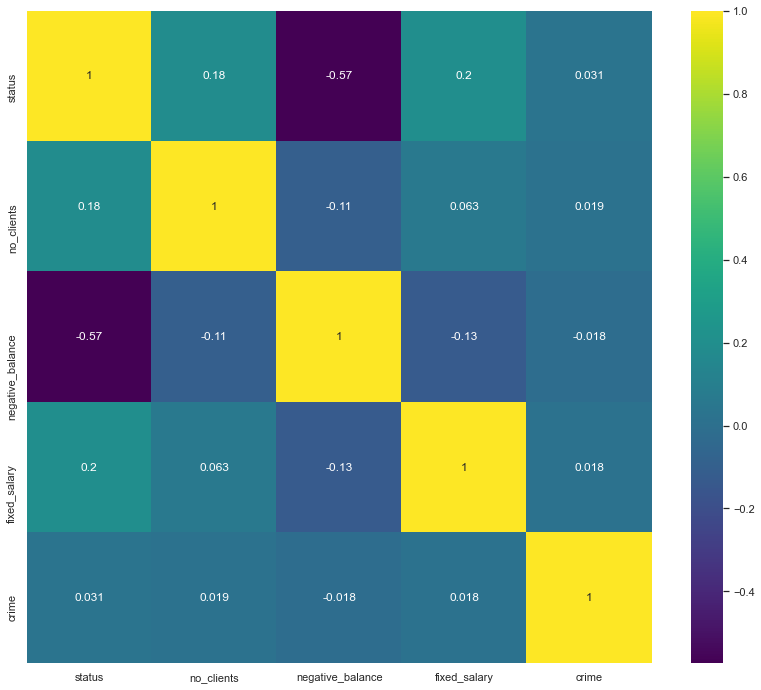

In [257]:
sns.heatmap(f.corr(),cmap='viridis',annot=True)

In [258]:
f = f.astype({"payments": int, "issued": int,'avg_balance':int})
f['crime']=f['crime'].fillna(f['crime'].mean())

In [259]:
f['fixed_salary'].describe()

count      682.000000
mean     13724.325513
std      14175.094473
min          0.000000
25%        166.250000
50%      11740.500000
75%      22001.750000
max      49761.000000
Name: fixed_salary, dtype: float64

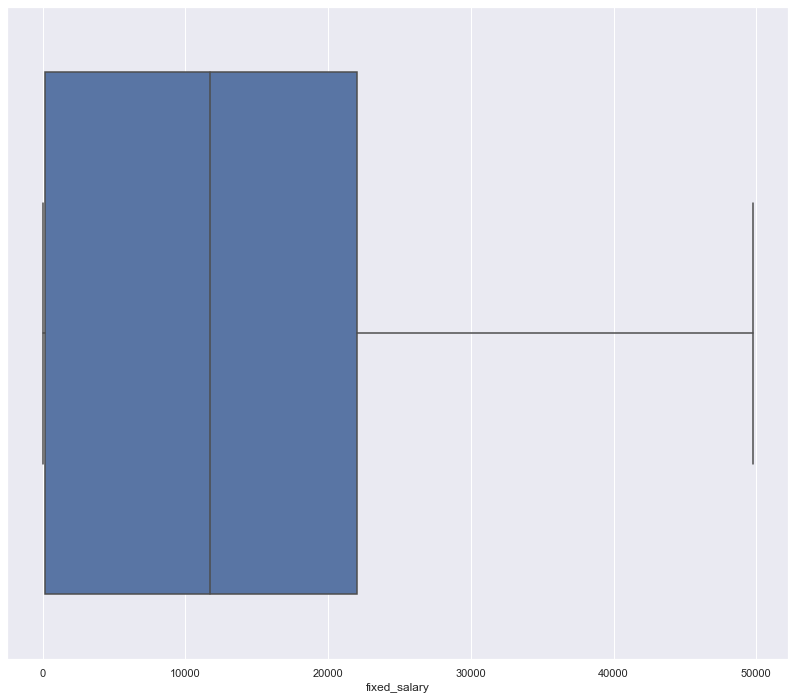

In [260]:
sns.boxplot(f['fixed_salary'])
sns.set(rc={'figure.figsize':(14,12)})

In [261]:
fe=f.iloc[:,[0,2,3,4,5,6,7]]
fe=fe.drop(columns=['avg_balance','crime'])
x_train=fe.values
y_train=f['status'].values

### USING SMOTE FOR BALANCING DATA (creating synthetic data points)

In [262]:
from imblearn.over_sampling import SMOTE 
sm = SMOTE(random_state=0)
x_train, y_train = sm.fit_resample(x_train, y_train)


In [263]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
x_train = sc.fit_transform(x_train)

### VARIANCE INFLATION FACTOR 

In [264]:
# variance inflation factor to check multi-collinearity between features.
from statsmodels.stats.outliers_influence import variance_inflation_factor

# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = fe.columns
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(x_train, i)
						for i in range(len(fe.columns))]

print(vif_data)

            feature       VIF
0          payments  1.018191
1            issued  1.037877
2        no_clients  1.057403
3  negative_balance  1.091169
4      fixed_salary  1.089954


## MODEL BUILDING 

In [265]:
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators = 20, criterion = 'entropy', random_state = 0)
classifier.fit(x_train, y_train),

(RandomForestClassifier(criterion='entropy', n_estimators=20, random_state=0),)

In [266]:
from sklearn.linear_model import LogisticRegression
classifier_lg = LogisticRegression(random_state = 0)
classifier_lg.fit(x_train, y_train)

LogisticRegression(random_state=0)

In [267]:
from sklearn.naive_bayes import GaussianNB
classifier_nv = GaussianNB()
classifier_nv.fit(x_train, y_train)

GaussianNB()

In [268]:
y_pred = classifier.predict(x_train)
y_pred_lg = classifier_lg.predict(x_train)
y_pred_nv = classifier_nv.predict(x_train)

In [269]:
from sklearn.metrics import confusion_matrix, accuracy_score,f1_score,precision_score,recall_score,cohen_kappa_score
cm = confusion_matrix(y_train, y_pred)
print(cm)
accuracy_score(y_train, y_pred)


[[606   0]
 [  3 603]]


0.9975247524752475

In [270]:
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_train, y_pred_lg)
print(cm)
accuracy_score(y_train, y_pred_lg)

[[495 111]
 [ 99 507]]


0.8267326732673267

In [271]:
print(confusion_matrix(y_train, y_pred_svm))
accuracy_score(y_train, y_pred_svm)

[[490 116]
 [ 74 532]]


0.8432343234323433

In [272]:
print(confusion_matrix(y_train, y_pred_nv))
accuracy_score(y_train, y_pred_nv)

[[596  10]
 [213 393]]


0.816006600660066

In [273]:
f1_score(y_train, y_pred_lg)

0.8284313725490197

In [274]:
precision_score(y_train, y_pred_lg)

0.8203883495145631

In [275]:
f1_score(y_train, y_pred_svm)

0.8484848484848486

### STRATIFIED K-FOLD 

In [276]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=3,shuffle=True,random_state=0)
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = classifier_lg, X = x_train, y = y_train, cv = skf,scoring='f1')# stratified by deafult.
print("Accuracy: {:.2f} %".format(accuracies.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))

Accuracy: 82.97 %
Standard Deviation: 1.95 %


In [277]:
print(accuracies)

[0.8377724  0.80288462 0.84848485]


In [278]:
cohen_kappa_score(y_train, y_pred)

0.995049504950495

In [279]:
cohen_kappa_score(y_train,y_pred)

0.995049504950495

### PROPER IMPLEMENTATION OF REPEATED STRATIFIED K-FOLD 

In [280]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.pipeline import Pipeline
steps = list()
steps.append(('scaler', StandardScaler()))
steps.append(('log_model', LogisticRegression(random_state=0,C=0.00001)))
pipeline = Pipeline(steps=steps)
# define the evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
# evaluate the model using cross-validation
scores = cross_val_score(pipeline, x_train, y_train, scoring='f1', cv=cv, n_jobs=-1)
# report performance
print('f1_score: mean: {} , std :{}'.format(scores.mean()*100, scores.std()*100))

f1_score: mean: 81.3485323661658 , std :3.627310607374865


In [281]:
scores

array([0.7638191 , 0.82191781, 0.83950617, 0.78632479, 0.81896552,
       0.7638191 , 0.86330935, 0.8220339 , 0.82845188, 0.82905983,
       0.73096447, 0.84507042, 0.81034483, 0.81578947, 0.86290323])

In [282]:
classifier_lg.coef_

array([[-0.58294761,  1.20142951,  1.71546139, -3.84144467,  0.69209643]])

## DEPLOYMENT 

In [285]:
import pickle
filename = 'credit_model.pkl'
pickle.dump(classifier_lg, open(filename, 'wb'))

In [286]:
pickle.dump(sc, open('scaler.pkl', 'wb'))